In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pylab
import re

from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 

from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.metrics import accuracy_score, roc_curve, auc, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

import optuna
import warnings
warnings.filterwarnings('ignore')

In [8]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv',index_col='id' )
df_test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv',index_col='id' )
df_sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e12/sample_submission.csv')

In [9]:
y = df_train['Premium Amount']
X = df_train.drop(columns=['Premium Amount']) 

In [10]:
df_train.isna().sum()

Age                      18705
Gender                       0
Annual Income            44949
Marital Status           18529
Number of Dependents    109672
Education Level              0
Occupation              358075
Health Score             74076
Location                     0
Policy Type                  0
Previous Claims         364029
Vehicle Age                  6
Credit Score            137882
Insurance Duration           1
Policy Start Date            0
Customer Feedback        77824
Smoking Status               0
Exercise Frequency           0
Property Type                0
Premium Amount               0
dtype: int64

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   Age                   1181295 non-null  float64
 1   Gender                1200000 non-null  object 
 2   Annual Income         1155051 non-null  float64
 3   Marital Status        1181471 non-null  object 
 4   Number of Dependents  1090328 non-null  float64
 5   Education Level       1200000 non-null  object 
 6   Occupation            841925 non-null   object 
 7   Health Score          1125924 non-null  float64
 8   Location              1200000 non-null  object 
 9   Policy Type           1200000 non-null  object 
 10  Previous Claims       835971 non-null   float64
 11  Vehicle Age           1199994 non-null  float64
 12  Credit Score          1062118 non-null  float64
 13  Insurance Duration    1199999 non-null  float64
 14  Policy Start Date     1200000 non-null 

In [12]:
numerical_columns = X.select_dtypes(include=['number']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

In [13]:
numerical_columns

Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object')

In [14]:
categorical_columns

Index(['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location',
       'Policy Type', 'Policy Start Date', 'Customer Feedback',
       'Smoking Status', 'Exercise Frequency', 'Property Type'],
      dtype='object')

In [15]:

categorical_columns = categorical_columns.drop('Policy Start Date')

In [ ]:
df_train['Annual Income'].quantile(0.025)

### Exploratory Data Analysis

In [ ]:
# Calculate missing percentages
categorical_missing_percentages = df_train[categorical_columns].isnull().sum() / len(df_train) * 100
categorical_missing_percentages = categorical_missing_percentages[categorical_missing_percentages > 0]

categorical_missing_percentages

In [ ]:
# Create the barplot
sns.barplot(x=categorical_missing_percentages.index, y=categorical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

In [ ]:
# Calculate missing percentages for numerical columns
numerical_missing_percentages = df_train[numerical_columns].isnull().sum() / len(df_train) * 100
numerical_missing_percentages = numerical_missing_percentages[numerical_missing_percentages > 0]

numerical_missing_percentages

In [ ]:
# Create the barplot
sns.barplot(x=numerical_missing_percentages.index, y=numerical_missing_percentages.values)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Label the axes
plt.xlabel('Features')
plt.ylabel('Percentage of Missing Values')

# Display the plot
plt.show()

### Exploratory Data Analytics

#### Target Variable Analysis

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Premium Amount'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Premium Amount', xlabel='', ylabel='Premium Amount')

# Histogram with KDE on the right
sns.histplot(df_train['Premium Amount'], kde=True, bins=50, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Premium Amount', xlabel='Premium Amount', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

### Categorical Variables Distribution with Premium Amount

In [ ]:

for column in categorical_columns:
    print(f'Column: {column}')
    print(df_train[column].value_counts())

In [ ]:
df_train[categorical_columns].isna().sum()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Marital Status',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Marital Status', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Occupation',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Occupation', fontsize=16)

# Show the plot
plt.show()

In [ ]:
# Using sns.displot for faceted histogram
sns.displot(
    data=df_train,
    x='Premium Amount',
    col='Education Level',
    kde=True,  # Add KDE curve for smoothness
    col_wrap=3,  # Number of facets per row (adjust as needed)
    bins=10,  # Number of bins
    height=4,  # Height of each facet
    aspect=1.2,  # Aspect ratio of each facet
    palette = 'Set2'# Optional color
)

# Adding a title to the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of Premium Amount Faceted by Education Level', fontsize=16)

# Show the plot
plt.show()

In [ ]:

sns.distplot(
    data=df_train,
    x='Credit Score',
    y='Premium Amount',
    col='Policy Type',       # Facet by Location
    hue='Policy Type',       # Optional for consistent colors across facets
    kind='scatter',       # Type of plot
    alpha=0.7,            # Transparency for better visibility
    col_wrap=3,           # Number of facets per row
    height=4,             # Height of each facet
    aspect=1.2            # Aspect ratio of each facet
)

# Add a title for the entire plot
plt.subplots_adjust(top=0.9)
plt.suptitle('Credit Score vs Premium Amount Faceted by Policy Type', fontsize=16)

# Show the plot
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 2]})

# Box plot on the left
sns.boxplot(y=df_train['Annual Income'], ax=axes[0], color='skyblue')
axes[0].set(title='Box Plot of Annual Income', xlabel='', ylabel='Annual Income')

# Histogram with KDE on the right
sns.histplot(df_train['Annual Income'], kde=True, bins=15, ax=axes[1], color='green')
axes[1].set(title='Histogram and KDE of Annual Income', xlabel='Annual Income', ylabel='Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.countplot(
    data=df_train,
    x='Number of Dependents', 
    palette='viridis',         # Optional color palette
    linewidth=2                # Line thickness
)

# Adding labels and title
plt.title(' Number of Dependents Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# Line plot with seaborn
plt.figure(figsize=(12, 6))
sns.histplot(
    x=df_train['Credit Score'], 
    palette='viridis',         # Optional color palette
    kde=True,
    bins=10
)

# Adding labels and title
plt.title(' Credit Score Distribution', fontsize=16)  
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:

# Bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_train,
    x='Policy Type',
    y='Premium Amount',
    ci=None,  # Remove confidence intervals for cleaner visualization
    palette='Set2'
)

# Adding labels and title
plt.title('Average Premium Amount by Policy Type', fontsize=16)
plt.xlabel('Policy Type', fontsize=14)
plt.ylabel('Average Premium Amount', fontsize=14)
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

### Feature Engineering

#### Categorical Column Missing Value Impute

In [16]:

class NumericalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute numerical columns with specified strategies.
    """
    def __init__(self, impute_dict=None):
        """
        Initialize the transformer with a dictionary of imputation strategies.

        Args:
        - impute_dict (dict): Dictionary mapping column names to imputation strategies.
          e.g., {'Age': 'median', 'Number of Dependents': 0}
        """
        self.impute_dict = impute_dict

    def fit(self, X, y=None):
        """
        Fit the transformer by calculating the required statistics for each column.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        self.statistics_ = {}
        for col, strategy in self.impute_dict.items():
            if strategy == "median":
                self.statistics_[col] = X[col].median()
            elif strategy == "mean":
                self.statistics_[col] = X[col].mean()
            elif strategy == 0:  # Use 0 for imputation
                self.statistics_[col] = 0
            else:
                raise ValueError(f"Unsupported strategy: {strategy}")
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col, value in self.statistics_.items():
            X[col] = X[col].fillna(value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return list(self.impute_dict.keys())

In [17]:

# Custom DateTimeConverter transformer
class DateTimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feature_names_ = None  # Initialize a variable to store feature names

    def fit(self, X, y=None):
        # Save feature names during the fit step (this is the DataFrame's column names)
        self.feature_names_ = X.columns
        return self

    def transform(self, X):
        # Convert the date columns to datetime format
        X_transformed = X.apply(pd.to_datetime, errors='coerce')  # Invalid dates will become NaT
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        if self.feature_names_ is None:
            raise RuntimeError("The transformer has not been fit yet.")
        return self.feature_names_


In [18]:
# Custom Categorical Imputer Class
class CategoricalImputer(BaseEstimator, TransformerMixin):
    """
    Custom transformer to impute categorical columns with a specified fill value.
    """
    def __init__(self, columns=None, fill_value="Not Available"):
        """
        Initialize the transformer.

        Args:
        - columns (list): List of column names to impute.
        - fill_value (str): The value to impute missing entries with. Defaults to 'Not Available'.
        """
        self.columns = columns
        self.fill_value = fill_value

    def fit(self, X, y=None):
        """
        Fit the transformer. This is a no-op as no fitting is required for simple imputation.

        Args:
        - X (pd.DataFrame): Input data.
        - y: Ignored.
        
        Returns:
        - self: Fitted transformer.
        """
        if self.columns is None:
            self.columns = X.columns.tolist()  # If no specific columns, impute all.
        return self

    def transform(self, X):
        """
        Transform the data by imputing the specified columns.

        Args:
        - X (pd.DataFrame): Input data.

        Returns:
        - pd.DataFrame: Transformed data with imputed values.
        """
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.fill_value)
        return X

    def get_feature_names_out(self, input_features=None):
        """
        Get output feature names for compatibility with ColumnTransformer.

        Args:
        - input_features (array-like or None): Input feature names. Ignored in this implementation.

        Returns:
        - list: Feature names (column names) after transformation.
        """
        return self.columns

In [19]:

# Create the CategoricalImputer instance 
categorical_imputer =  CategoricalImputer()

categorical_imputer_pipeline = Pipeline(steps=[
     ('impute_value', categorical_imputer),
     ('ohe_impute_col',OneHotEncoder(handle_unknown='ignore', drop='first') )
 ])

In [20]:
 df_train['Policy Start Date'].isna().sum()

0

In [21]:

# Define the imputation strategies
impute_strategies = {
    'Age': 'median',
    'Annual Income': 'median',
    'Number of Dependents': 0,
    'Health Score': 'mean',
    'Previous Claims': 0,
    'Vehicle Age': 'median',
    'Credit Score': 'median',
    'Insurance Duration': 'median'
}

# Create the custom transformer for numerical imputation
numerical_imputer = NumericalImputer(impute_dict=impute_strategies)

# Define the numerical pipeline
numerical_pipeline = Pipeline(steps=[
    ('num_processing', numerical_imputer),  # Apply numerical imputation and outlier handling
    ('scaling', StandardScaler())  # Apply standard scaling
])


In [ ]:

# Example columns
date_columns = ['Policy Start Date']

date_pipeline = Pipeline(steps = [
    ("date_transformation",DateTimeConverter()),
])

In [22]:

# Define the categorical columns to be imputed
categorical_impute_columns = ['Marital Status', 'Occupation', 'Customer Feedback']
remaining_cat_columns = [col for col in categorical_columns if col not in categorical_impute_columns]

# ColumnTransformer with preprocessor pipeline
preprocessor = ColumnTransformer(
    transformers=[
        
        ("cat_transformation", OneHotEncoder(handle_unknown='ignore', drop='first'), remaining_cat_columns),  # OneHotEncode other categorical columns
        ("cat_impute_transformation", categorical_imputer_pipeline, categorical_impute_columns),  # Impute categorical columns 
        ("num_transformation", numerical_pipeline, numerical_columns),  # Apply numerical transformations
    ],
    remainder='drop'  # Pass through any columns not explicitly transformed
)
 
# Create a pipeline with PCA or any other estimator after preprocessing
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)  # Apply preprocessing for both categorical and numerical columns
])


In [23]:
pipeline.fit(X)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat_transformation',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['Gender', 'Education Level',
                                                   'Location', 'Policy Type',
                                                   'Smoking Status',
                                                   'Exercise Frequency',
                                                   'Property Type']),
                                                 ('cat_impute_transformation',
                                                  Pipeline(steps=[('impute_value',
                                                                   CategoricalImputer()),
                                                                  ('ohe_impute_col',
                                                                   OneHotE...
                                                                   NumericalImputer(impute_dict={'Age': 'median',
                                                                                                 'Annual Income': 'median',
                                                                                                 'Credit Score': 'median',
                                                                                                 'Health Score': 'mean',
                                                                                                 'Insurance Duration': 'median',
                                                                                                 'Number of Dependents': 0,
                                                                                                 'Previous Claims': 0,
                                                                                                 'Vehicle Age': 'median'})),
                                                                  ('scaling',
                                                                   StandardScaler())]),
                                                  Index(['Age', 'Annual Income', 'Number of Dependents', 'Health Score',
       'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration'],
      dtype='object'))]))])

In [24]:
transformed_X = pipeline.transform(X)


In [25]:
 # Get the feature names after transformation
transformed_feature_names = preprocessor.get_feature_names_out()
transformed_feature_names


array(['cat_transformation__Gender_Male',
       'cat_transformation__Education Level_High School',
       "cat_transformation__Education Level_Master's",
       'cat_transformation__Education Level_PhD',
       'cat_transformation__Location_Suburban',
       'cat_transformation__Location_Urban',
       'cat_transformation__Policy Type_Comprehensive',
       'cat_transformation__Policy Type_Premium',
       'cat_transformation__Smoking Status_Yes',
       'cat_transformation__Exercise Frequency_Monthly',
       'cat_transformation__Exercise Frequency_Rarely',
       'cat_transformation__Exercise Frequency_Weekly',
       'cat_transformation__Property Type_Condo',
       'cat_transformation__Property Type_House',
       'cat_impute_transformation__Marital Status_Married',
       'cat_impute_transformation__Marital Status_Not Available',
       'cat_impute_transformation__Marital Status_Single',
       'cat_impute_transformation__Occupation_Not Available',
       'cat_impute_transformati

In [26]:
df_transformed_X =  pd.DataFrame(transformed_X, columns=transformed_feature_names)


In [27]:
df_transformed_X

,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,cat_transformation__Education Level_PhD,cat_transformation__Location_Suburban,cat_transformation__Location_Urban,cat_transformation__Policy Type_Comprehensive,cat_transformation__Policy Type_Premium,cat_transformation__Smoking Status_Yes,cat_transformation__Exercise Frequency_Monthly,...,cat_impute_transformation__Customer Feedback_Not Available,cat_impute_transformation__Customer Feedback_Poor,num_transformation__Age,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,-1.648301,-0.707414,-0.562091,-0.255071,1.383143,1.286338,-1.567375,-0.007023
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,-0.159542,-0.023289,0.798510,-0.849704,0.320400,0.420713,0.714630,-1.163391
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,-1.350549,-0.215473,0.798510,1.824212,0.320400,0.766963,0.013020,-0.777935
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,-1.499425,3.461605,0.118210,-1.241521,0.320400,-1.656788,-1.602810,-1.548847
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,-1.499425,0.228896,-0.562091,-0.443102,-0.742343,-0.271787,0.034281,-0.392479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199995,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,1.0,-0.382856,-0.161259,-1.242391,-1.001709,-0.742343,-0.791163,-1.567375,-0.777935
1199996,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.957026,0.106646,-1.242391,-1.195387,-0.742343,0.074463,0.027194,-0.392479
1199997,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,-1.648301,0.615826,-1.242391,-0.921210,-0.742343,1.632588,0.013020,0.378433
1199998,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.031464,-0.268959,-0.562091,-0.597805,0.320400,-0.444912,-1.319331,-0.392479


In [ ]:
df_transformed_X.head()

### Transform Test Data

In [28]:
test_transformed = pipeline.transform(df_test)

In [29]:
df_test_transformed=  pd.DataFrame(test_transformed, columns=transformed_feature_names)


In [30]:
df_test_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800000 entries, 0 to 799999
Data columns (total 31 columns):
 #   Column                                                      Non-Null Count   Dtype  
---  ------                                                      --------------   -----  
 0   cat_transformation__Gender_Male                             800000 non-null  float64
 1   cat_transformation__Education Level_High School             800000 non-null  float64
 2   cat_transformation__Education Level_Master's                800000 non-null  float64
 3   cat_transformation__Education Level_PhD                     800000 non-null  float64
 4   cat_transformation__Location_Suburban                       800000 non-null  float64
 5   cat_transformation__Location_Urban                          800000 non-null  float64
 6   cat_transformation__Policy Type_Comprehensive               800000 non-null  float64
 7   cat_transformation__Policy Type_Premium                     800000 non-nul

In [31]:
df_test_transformed

,cat_transformation__Gender_Male,cat_transformation__Education Level_High School,cat_transformation__Education Level_Master's,cat_transformation__Education Level_PhD,cat_transformation__Location_Suburban,cat_transformation__Location_Urban,cat_transformation__Policy Type_Comprehensive,cat_transformation__Policy Type_Premium,cat_transformation__Smoking Status_Yes,cat_transformation__Exercise Frequency_Monthly,...,cat_impute_transformation__Customer Feedback_Not Available,cat_impute_transformation__Customer Feedback_Poor,num_transformation__Age,num_transformation__Annual Income,num_transformation__Number of Dependents,num_transformation__Health Score,num_transformation__Previous Claims,num_transformation__Vehicle Age,num_transformation__Credit Score,num_transformation__Insurance Duration
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,-0.978359,-0.952198,1.478811,-1.519011,-0.742343,1.632588,0.013020,-1.548847
1,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,-0.755046,2.961093,0.118210,-1.034831,-0.742343,0.766963,-1.567375,1.149346
2,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.435961,-0.484644,-1.242391,-0.106539,-0.742343,1.113213,1.600501,1.534802
3,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,-0.978359,-0.062953,0.798510,-1.732344,0.320400,-1.137413,1.253240,-0.007023
4,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-1.276111,-0.681667,0.118210,-1.164875,-0.742343,0.766963,1.146935,0.763890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.659275,0.201410,-0.562091,-0.940315,-0.742343,-0.271787,-2.013854,-1.163391
799996,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,-0.010667,1.298337,-1.242391,-1.477748,1.383143,-1.656788,0.013020,-1.163391
799997,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,-1.127235,0.087415,-1.242391,-1.605418,-0.742343,0.074463,0.013020,0.378433
799998,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,-0.531732,0.418992,0.798510,-0.818613,1.383143,1.286338,-0.894112,0.763890


### Apply Machine Learning Alogrithms

#### XGBoost Regression

In [35]:
# Define the XGBoost model for regression
xgb_model = XGBRegressor()

# Define hyperparameters for tuning
param_grid = {
    'n_estimators': [   100 ],
    'learning_rate': [  0.01 ],
    'max_depth': [ 5, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0], 
}

# Perform hyperparameter tuning using GridSearchCV
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring
    verbose=1
)

In [36]:

grid_search_xgb.fit(df_transformed_X, y)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01], 'max_depth': [5, 10],
                         'n_estimators': [100], 'subsample': [0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [37]:

# Print best parameters and best score
print("Best Parameters:", grid_search_xgb.best_params_)
print("Best CV Score (Negative MSE):", grid_search_xgb.best_score_)

# Get the best model from grid search
best_xg_model = grid_search_xgb.best_estimator_

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
Best CV Score (Negative MSE): -711567.7948197749


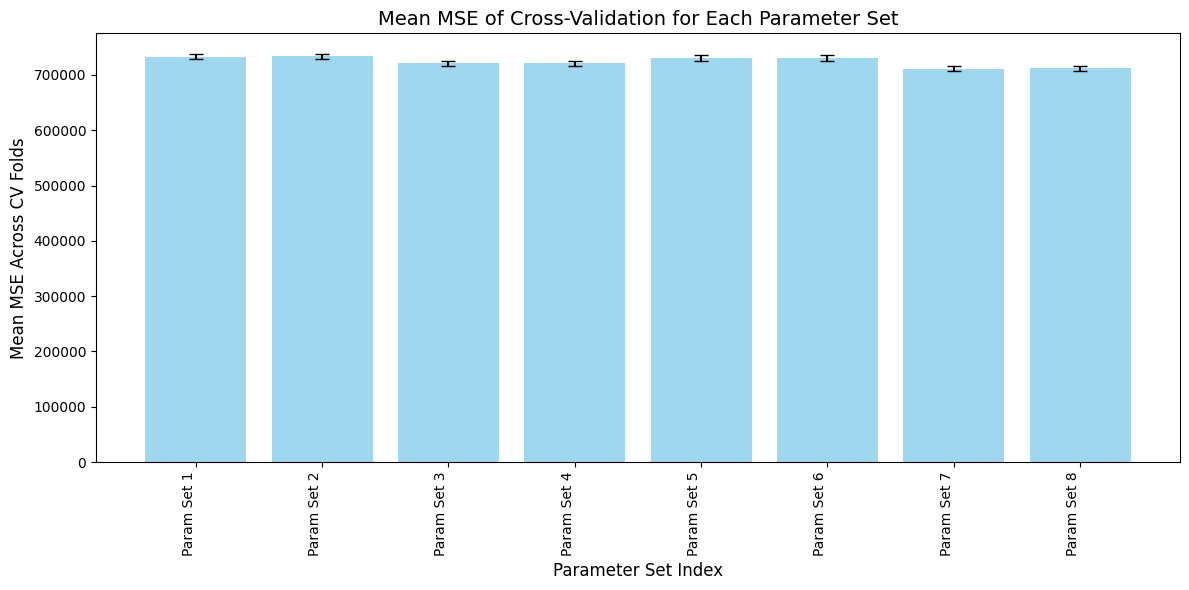

In [38]:
# Get the mean test scores for each parameter combination
mean_test_scores = grid_search_xgb.cv_results_['mean_test_score']
std_test_scores = grid_search_xgb.cv_results_['std_test_score']

# Convert negative MSE to positive MSE for better interpretation
mean_test_scores = -mean_test_scores  # Convert negative MSE to positive
std_test_scores = std_test_scores

# Create a bar chart
x_labels = [f"Param Set {i+1}" for i in range(len(mean_test_scores))]
x_pos = np.arange(len(mean_test_scores))

plt.figure(figsize=(12, 6))
plt.bar(x_pos, mean_test_scores, yerr=std_test_scores, capsize=5, color='skyblue', alpha=0.8)

# Add labels and title
plt.xlabel("Parameter Set Index", fontsize=12)
plt.ylabel("Mean MSE Across CV Folds", fontsize=12)
plt.title("Mean MSE of Cross-Validation for Each Parameter Set", fontsize=14)
plt.xticks(x_pos, x_labels, rotation=90, ha='right', fontsize=10)
plt.tight_layout()

plt.show()

In [39]:

# Make predictions on the test set
y_pred_xgb = best_xg_model.predict(df_test_transformed)


In [40]:
output_xgb = pd.DataFrame(y_pred_xgb, index=df_test.index, columns=['Premium Amount']).reset_index()

In [41]:
output_xgb.head(20)

,id,Premium Amount
0,1200000,1150.896606
1,1200001,1109.249878
2,1200002,1092.432251
3,1200003,1097.052979
4,1200004,1063.834595
5,1200005,1102.864868
6,1200006,1198.660156
7,1200007,1049.653687
8,1200008,705.761108
9,1200009,1103.718750


In [46]:
submission = output_xgb.to_csv('/kaggle/working/submission.csv', index=False)

In [47]:

# Create a DataFrame to show the importance of each original feature
importance_df = pd.DataFrame({
    'Original Feature': transformed_feature_names,  # Replace with actual feature names
    'Importance': best_xg_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(importance_df)

                                     Original Feature  Importance
21  cat_impute_transformation__Customer Feedback_N...    0.308526
27                num_transformation__Previous Claims    0.139924
15  cat_impute_transformation__Marital Status_Not ...    0.125437
24                  num_transformation__Annual Income    0.096717
26                   num_transformation__Health Score    0.079363
29                   num_transformation__Credit Score    0.042142
17  cat_impute_transformation__Occupation_Not Avai...    0.011447
25           num_transformation__Number of Dependents    0.009721
23                            num_transformation__Age    0.009455
22  cat_impute_transformation__Customer Feedback_Poor    0.009244
28                    num_transformation__Vehicle Age    0.009213
12            cat_transformation__Property Type_Condo    0.009184
30             num_transformation__Insurance Duration    0.009058
16   cat_impute_transformation__Marital Status_Single    0.008645
19   cat_i

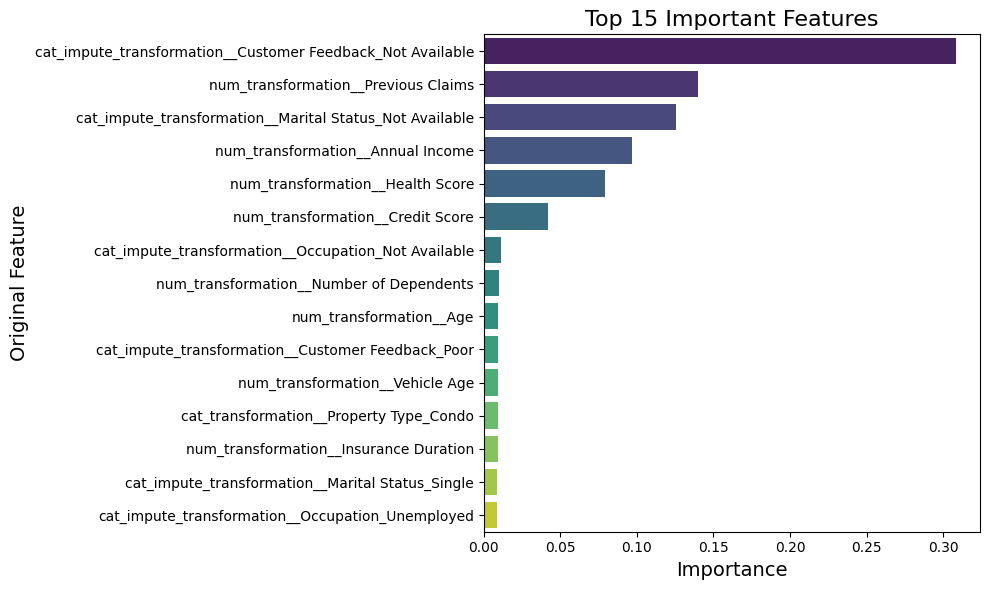

In [48]:
# Assuming the importance_df is already computed as described earlier:
# Sort the DataFrame by importance in descending order and select top 15 features
top_features = importance_df.sort_values(by='Importance', ascending=False).head(15)

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Original Feature', data=top_features, palette='viridis')

# Add labels and title
plt.title('Top 15 Important Features', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Original Feature', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()